In [10]:
!pip install pulp

  Using cached PuLP-2.9.0-py3-none-any.whl (17.7 MB)


## Using pulp to solve maximum colourful subtrees problem
This is example code based on the fragmentation tree concept of mass spectra prediction. 

**Objective:** The objective now focuses on maximizing the number of nodes (ie the number of matched peaks in the spectra)
(pulp.lpSum([node_vars[n] for n in peaks.keys()])). 

**Transition Probability** : Transition probabilities are calculated based on the intensity of the preceding node (u in each edge (u, v)). This aligns with your requirement of using the precursor node to compute the transition.

**Constraint on Transition Probability (Optional):** A constraint has been added to allow only edges with a transition probability greater than a given threshold (min_transition_prob). This can be adjusted based on your requirements. If you want to completely ignore transition probabilities in the constraints, you can simply remove this block.

**Nodes:** Each peak is a node, and we want to maximize the total number of selected nodes.

**Edges:** Represent potential fragmentation pathways. These are selected based on the precursor-to-fragment transition probability. In this example edges are defined based on common_losses (like the original fragmentation tree paper) but I would like to ground this in chemistry.

**Transition Probability Calculation:** Transition probability between two peaks is calculated as the ratio of the fragment peak’s intensity to the precursor peak’s intensity. The result is used to filter or prioritise certain edges during the subtree selection.

**Edge Selection Constraints:** The constraint ensures that if an edge is selected, both the precursor and fragment peaks (nodes) must be included in the subtree.

In [11]:
import itertools
import pulp
import pandas as pd
import random
import numpy as np
import networkx as nx

In [12]:
# Create the mass spectra data as a pandas DataFrame
data = {'mz': [118, 136.0, 144.0, 162.0, 180.0], 
        #'intensity': [15, 15.0, 10, 30.0, 30.0]} # fully explainable example
        'intensity': [7, 18.0, 12, 82.0, 21.0]} # random intensity example
peaks_df = pd.DataFrame(data)

# Sort by m/z in descending order to ensure precursor (largest m/z) comes first
peaks_df = peaks_df.sort_values(by='mz', ascending=False).reset_index(drop=True)

# Define common fragment losses (e.g., H₂O, CO₂, etc. in Da)
common_losses = [18.0, 44.0]

# Generate potential edges based on common losses (from precursor to fragment)
edges = []
for i, j in itertools.combinations(peaks_df.index, 2):
    mz_diff = abs(peaks_df.loc[i, 'mz'] - peaks_df.loc[j, 'mz'])
    if mz_diff in common_losses:
        edges.append((i, j))

print(f"Suggested edges based on fragment losses: {edges}")

# Create a binary decision variable for each node: 1 if it's part of the subtree, 0 otherwise
node_vars = pulp.LpVariable.dicts("node", peaks_df.index, 0, 1, pulp.LpBinary)

# Create a binary decision variable for each edge: 1 if both nodes in the edge are part of the subtree, 0 otherwise
edge_vars = pulp.LpVariable.dicts("edge", edges, 0, 1, pulp.LpBinary)

# Initialize the ILP problem
prob = pulp.LpProblem("MaximizeNodes", pulp.LpMaximize)

# Objective: Maximize the number of nodes selected in the subtree
prob += pulp.lpSum([node_vars[n] for n in peaks_df.index]), "Maximize number of nodes"

# Constraints: If an edge is selected, both its nodes must be selected
for u, v in edges:
    prob += edge_vars[(u, v)] <= node_vars[u], f"Edge_{u}_{v}_u"
    prob += edge_vars[(u, v)] <= node_vars[v], f"Edge_{u}_{v}_v"
    prob += edge_vars[(u, v)] >= node_vars[u] + node_vars[v] - 1, f"Edge_{u}_{v}_connection"

# Solve the problem
prob.solve()

# Collect selected nodes and edges after solving the tree
selected_nodes = [n for n in peaks_df.index if node_vars[n].varValue == 1]
selected_edges = [e for e in edges if edge_vars[e].varValue == 1]

print(f"Selected nodes: {selected_nodes}")
print(f"Selected edges: {selected_edges}")

# == Tidying up unassigned nodes ==
connected_nodes = set()
for u, v in selected_edges:
    connected_nodes.add(u)
    connected_nodes.add(v)

# Generate a list of the m/z values of the nodes in connected_nodes
connected_peaks_df = peaks_df.loc[list(connected_nodes)]

print("Connected nodes (with m/z values):")
print(connected_peaks_df[['mz', 'intensity']])

print(edges)

Suggested edges based on fragment losses: [(0, 1), (0, 3), (1, 2), (1, 4), (3, 4)]
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /opt/conda/lib/python3.9/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/f8444cd7409148a59c0d7113b4acccdd-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /tmp/f8444cd7409148a59c0d7113b4acccdd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 20 COLUMNS
At line 81 RHS
At line 97 BOUNDS
At line 108 ENDATA
Problem MODEL has 15 rows, 10 columns and 35 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 5 - 0.00 seconds
Cgl0004I processed model has 15 rows, 10 columns (10 integer (10 of which binary)) and 35 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -5
Cbc0038I Before mini branch and bound, 10 inte

## Due to the iterative nature use a genetic algorithm to solve the probability problem.

Key Steps in the Genetic Algorithm:
Fitness Function: We calculate how well the transition probabilities explain the node intensities. The goal is to minimize the difference between the calculated and observed intensities.
Selection: We use roulette-wheel selection based on fitness scores to select parents.
Crossover and Mutation: Genetic operators are applied to evolve better solutions.

Explanation:
Initialization: We start with random transition probabilities for each edge.
Evaluation: The fitness function compares the calculated intensities with the observed intensities and rewards the solutions that minimize the difference.
Selection: We pick parents based on their fitness, with higher fitness individuals more likely to be selected.
Crossover: New solutions (offspring) are generated by combining the transition probabilities from two parents.
Mutation: We introduce randomness to explore new solutions, allowing for small changes in transition probabilities.
    

In [13]:
# Define parameters for the GA
population_size = 50  # Number of individuals in each generation
generations = 1000  # Number of generations to evolve
mutation_rate = 0.1  # Probability of mutating a transition probability
tolerance = 0.05  # Error tolerance for intensity difference

def fitness_function1(transition_probs, edges, peaks_df, tolerance=0.05):
    """
    Calculate the fitness score based on propagating intensities from the precursor ion.
    Handle cases where a node is formed by contributions from multiple precursors.
    The precursor node loses intensity as it transitions to a fragment.
    """
    # Create a directed graph of the fragmentation tree to calculate the topological order
    G = nx.DiGraph()
    G.add_edges_from(edges)

    # Perform topological sort (ensures we process precursors before their fragments)
    topo_order = list(nx.topological_sort(G))

    # Initialize the calculated intensities list, starting with the precursor node (highest m/z)
    calculated_intensities = {i: 0 for i in peaks_df.index}
    precursor_node = topo_order[0]  # The first node in topological order (precursor)
    calculated_intensities[precursor_node] = 1  # Set precursor intensity to 1

    # Normalize transition probabilities for each node
    for node in topo_order:
        outgoing_edges = [(i, j) for (i, j) in edges if i == node]
        total_prob = sum(transition_probs[(node, j)] for _, j in outgoing_edges)
        
        # Normalize probabilities if the total exceeds 1
        if total_prob > 1:
            for _, j in outgoing_edges:
                transition_probs[(node, j)] /= total_prob

    # Propagate the intensity through the nodes based on transition probabilities
    for node in topo_order:
        for (i, j) in edges:
            if i == node:
                # Calculate the intensity transition from node i to node j
                transition_intensity = calculated_intensities[i] * transition_probs[(i, j)]
                
                # Reduce the intensity of node i as it fragments
                calculated_intensities[i] -= transition_intensity
                
                # Add the transition intensity to node j (fragment)
                calculated_intensities[j] += transition_intensity

    # Compare the calculated intensities with observed intensities and calculate the fitness
    score = 0
    for node in peaks_df.index:
        observed_intensity = peaks_df.loc[node, 'intensity'] / 100  # Normalize observed intensity
        calculated_intensity = calculated_intensities[node]

        # Penalize the difference between calculated and observed intensity
        if observed_intensity > 0:  # Avoid division by zero
            error = abs(calculated_intensity - observed_intensity) / observed_intensity
        else:
            error = 0 if calculated_intensity == 0 else 1  # Penalize non-zero calculated values when observed is zero
        
        if error <= tolerance:
            score += 1 - error  # Reward small errors
        else:
            score -= error  # Penalize larger errors

    return score

def fitness_function(transition_probs, edges, peaks_df, tolerance=0.05):
    """
    Calculate the fitness score based on propagating intensities from the precursor ion.
    Handle cases where a node is formed by contributions from multiple precursors.
    The precursor node loses intensity as it transitions to fragments, 
    but the intensity used for propagation is based on the initial intensity.
    """
    # Create a directed graph of the fragmentation tree to calculate the topological order
    G = nx.DiGraph()
    G.add_edges_from(edges)

    # Perform topological sort (ensures we process precursors before their fragments)
    topo_order = list(nx.topological_sort(G))

    # Initialize the calculated intensities list, starting with the precursor node (highest m/z)
    calculated_intensities = {i: 0 for i in peaks_df.index}
    precursor_node = topo_order[0]  # The first node in topological order (precursor)
    calculated_intensities[precursor_node] = 1  # Set precursor intensity to 1

    # Normalize transition probabilities for each node
    for node in topo_order:
        outgoing_edges = [(i, j) for (i, j) in edges if i == node]
        total_prob = sum(transition_probs[(node, j)] for _, j in outgoing_edges)
        
        # Normalize probabilities if the total exceeds 1
        if total_prob > 1:
            for _, j in outgoing_edges:
                transition_probs[(node, j)] /= total_prob

    # Create a dictionary to store the initial intensities for distribution
    initial_intensities = calculated_intensities.copy()

    # Propagate the intensity through the nodes based on transition probabilities
    for node in topo_order:
        outgoing_edges = [(i, j) for (i, j) in edges if i == node]
        total_prob = sum(transition_probs[(node, j)] for _, j in outgoing_edges)
        
        totalTransition_intensityChange = calculated_intensities[node] * total_prob
        
        for (i, j) in edges:
            if i == node:
                # Calculate the intensity transition from node i to node j
                transition_intensity = calculated_intensities[i] * transition_probs[(i, j)]
                
                # Add the transition intensity to node j (fragment)
                calculated_intensities[j] += transition_intensity

        calculated_intensities[node] -= totalTransition_intensityChange

    # Compare the calculated intensities with observed intensities and calculate the fitness
    score = 0
    for node in peaks_df.index:
        observed_intensity = peaks_df.loc[node, 'intensity'] / 100  # Normalize observed intensity
        calculated_intensity = calculated_intensities[node]

        # Penalize the difference between calculated and observed intensity
        if observed_intensity > 0:  # Avoid division by zero
            error = abs(calculated_intensity - observed_intensity) / observed_intensity
        else:
            error = 0 if calculated_intensity == 0 else 1  # Penalize non-zero calculated values when observed is zero
        
        if error <= tolerance:
            score += 1 - error  # Reward small errors
        else:
            score -= error  # Penalize larger errors

    return score

def select_parents(population, fitness_scores):
    """
    Select parents using a simple roulette-wheel selection based on fitness scores.
    """
    # Ensure non-negative fitness scores
    min_fitness = min(fitness_scores)
    if min_fitness < 0:
        fitness_scores = [score - min_fitness + 1 for score in fitness_scores]  # Shift to positive range

    total_fitness = sum(fitness_scores)
    
    # Handle case where all fitness scores are the same
    if total_fitness == 0:
        selection_probs = [1 / len(fitness_scores) for _ in fitness_scores]
    else:
        selection_probs = [score / total_fitness for score in fitness_scores]
    
    parents = np.random.choice(population, size=2, p=selection_probs)
    return parents[0], parents[1]

def initialize_population(edges):
    """
    Initialize a population of random transition probabilities for each edge.
    """
    population = []
    for _ in range(population_size):
        individual = {}
        for (i, j) in edges:
            # Randomly assign a transition probability between 0 and 1 for each edge
            individual[(i, j)] = random.uniform(0, 1)
        population.append(individual)
    return population


def crossover(parent1, parent2):
    """
    Perform crossover between two parents to create an offspring.
    """
    offspring = {}
    for key in parent1:
        # Randomly select genes from either parent
        offspring[key] = parent1[key] if random.random() < 0.5 else parent2[key]
    return offspring

def mutate(individual):
    """
    Perform mutation on an individual by randomly adjusting some transition probabilities.
    """
    for key in individual:
        if random.random() < mutation_rate:
            # Add a small random value to the transition probability
            individual[key] += random.uniform(-0.1, 0.1)
            # Ensure the transition probability remains between 0 and 1
            individual[key] = max(0, min(1, individual[key]))
    return individual

def genetic_algorithm(edges, peaks_df, patience=10, epsilon=1e-6):
    # Initialize population
    population = initialize_population(edges)
    
    best_fitness = float('-inf')  # Best fitness score so far
    no_improvement_count = 0  # Count of generations without improvement

    for generation in range(generations):
        # Evaluate fitness for each individual
        fitness_scores = [fitness_function(individual, edges, peaks_df) for individual in population]
        
        # Find the best fitness score in this generation
        current_best_fitness = max(fitness_scores)
        
        # Check if we have an improvement over the best fitness score
        if current_best_fitness > best_fitness + epsilon:
            best_fitness = current_best_fitness
            no_improvement_count = 0  # Reset the counter if there's an improvement
        else:
            no_improvement_count += 1  # Increment the counter if no significant improvement
        
        # Early stopping: If no improvement for 'patience' generations, stop early
        if no_improvement_count >= patience:
            print(f"Early stopping after {generation} generations with best fitness: {best_fitness}")
            break

        # Create a new population by selecting, crossing over, and mutating
        new_population = []
        for _ in range(population_size // 2):
            # Select two parents
            parent1, parent2 = select_parents(population, fitness_scores)
            # Create offspring by crossover
            offspring1 = crossover(parent1, parent2)
            offspring2 = crossover(parent1, parent2)
            # Mutate offspring
            offspring1 = mutate(offspring1)
            offspring2 = mutate(offspring2)
            # Add offspring to the new population
            new_population.extend([offspring1, offspring2])
        
        # Replace the old population with the new one
        population = new_population
    
    # After evolving, return the best solution (with the highest fitness score)
    best_individual = max(population, key=lambda ind: fitness_function(ind, edges, peaks_df))
    return best_individual

# Call the GA to calculate transition probabilities
transition_probabilities = genetic_algorithm(edges, peaks_df)

# Print the final optimized transition probabilities
print(f"Optimized transition probabilities: {transition_probabilities}")



Early stopping after 23 generations with best fitness: 1.4336178543862144
Optimized transition probabilities: {(0, 1): 0.4640078952027774, (0, 3): 0.24064988917487634, (1, 2): 0.2651558428110542, (1, 4): 0.059129832825885464, (3, 4): 0.26298548456417054}


## Plotting the computed fragmentation tree

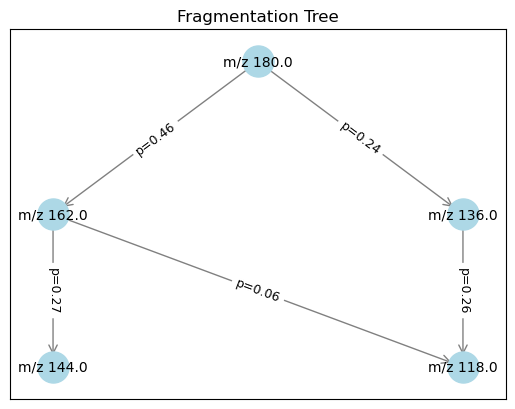

      mz  intensity
0  180.0       21.0
1  162.0       82.0
2  144.0       12.0
3  136.0       18.0
4  118.0        7.0


In [17]:
import networkx as nx
import matplotlib.pyplot as plt

def plot_fragmentation_tree(connected_peaks_df,transition_probabilities):
    # Create a directed graph
    G = nx.DiGraph()

    # Add nodes (peaks) to the graph
    for idx, row in connected_peaks_df.iterrows():
        G.add_node(idx, label=f"m/z {row['mz']}")

    # Add edges with m/z differences as labels
    mz_differences = {}
    for (u, v) in transition_probabilities.keys():
        if edge_vars[(u, v)].varValue == 1:  # Only add edges selected in the subtree
            mz_diff = abs(connected_peaks_df.loc[u, 'mz'] - connected_peaks_df.loc[v, 'mz'])
            G.add_edge(u, v, label=f"p={transition_probabilities[(u, v)]:.2f}")# f"Δm/z {mz_diff:.1f}, p={transition_probabilities[(u, v)]:.2f}")
            mz_differences[(u, v)] = mz_diff

    # Calculate node levels (distance from the precursor node)
    # Assuming the precursor is the node with the largest m/z (i.e., the root)
    precursor_node = 0  # Node with largest m/z (root)

    # Get the shortest path length from the precursor to each node (i.e., tree depth)
    node_depths = nx.single_source_shortest_path_length(G, precursor_node)

    # Group nodes by their depth (level in the tree)
    levels = {}
    for node, depth in node_depths.items():
        if depth not in levels:
            levels[depth] = []
        levels[depth].append(node)

    # Custom layout based on depth (levels) and horizontal spread
    pos = {}
    horizontal_spacing = 2.0  # Spacing between nodes at the same level
    vertical_spacing = 1.5    # Spacing between levels

    for depth, nodes in levels.items():
        # Spread nodes horizontally at each level
        num_nodes = len(nodes)
        for i, node in enumerate(nodes):
            pos[node] = (i * horizontal_spacing - num_nodes * horizontal_spacing / 2, -depth * vertical_spacing)

    # Draw the nodes
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightblue')

    # Draw the edges
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=15, edge_color='gray')

    # Draw the node labels (m/z values)
    node_labels = nx.get_node_attributes(G, 'label')
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color='black')

    # Draw the edge labels (m/z differences)
    edge_labels = nx.get_edge_attributes(G, 'label')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=9)

    # Set plot title
    plt.title("Fragmentation Tree")

    # Show the plot
    plt.show()

    
plot_fragmentation_tree(connected_peaks_df,transition_probabilities )
print(connected_peaks_df)

## Calculate spectra given the edges and transistion probabilities

In [15]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import pandas as pd

# Function to normalize spectrum to max intensity of 1
def normalize_spectrum(spectrum):
    max_intensity = spectrum['intensity'].max()
    spectrum['intensity'] = spectrum['intensity'] / max_intensity
    return spectrum

def calculate_node_intensities(edges, transition_probs, peaks_df):
    """
    Given the edges and transition probabilities, rebuild the spectrum by propagating intensities
    and return a DataFrame with the calculated m/z values and intensities. Precursor ions
    lose intensity as they fragments into other ions.
    """
    # Create a directed graph of the fragmentation tree
    G = nx.DiGraph()
    G.add_edges_from(edges)

    # Perform topological sort to process precursors before fragments
    topo_order = list(nx.topological_sort(G))

    # Initialize calculated intensities list, starting with the precursor node (highest m/z)
    calculated_intensities = {i: 0 for i in peaks_df.index}
    precursor_node = topo_order[0]  # The first node in topological order (precursor)
    calculated_intensities[precursor_node] = 1  # Set precursor intensity to 1 (arbitrary scale)

    # Propagate the intensity through the nodes based on transition probabilities
    for node in topo_order:
        outgoing_edges = [(i, j) for (i, j) in edges if i == node]
        total_prob = sum(transition_probs[(node, j)] for _, j in outgoing_edges)
        
        totalTransition_intensityChange = calculated_intensities[node] * total_prob
        
        for (i, j) in edges:
            if i == node:
                # Calculate the intensity transition from node i to node j
                transition_intensity = calculated_intensities[i] * transition_probs[(i, j)]
                
                # Add the transition intensity to node j (fragment)
                calculated_intensities[j] += transition_intensity

        calculated_intensities[node] -= totalTransition_intensityChange
                
    # Create a DataFrame with the calculated m/z and intensities
    calculated_spectrum = peaks_df.copy()
    calculated_spectrum['intensity'] = calculated_spectrum.index.map(calculated_intensities)

    return calculated_spectrum[['mz', 'intensity']]

# Example usage:
df_rebuilt_spectrum = calculate_node_intensities(edges, transition_probabilities, peaks_df)
print(df_rebuilt_spectrum)


      mz  intensity
0  180.0   0.295342
1  162.0   0.313537
2  144.0   0.123034
3  136.0   0.177362
4  118.0   0.090724


In [16]:
def cosine_similarity(df1, df2):
    """
    Calculate the cosine similarity between two DataFrames based on m/z and intensity columns.
    
    Parameters:
    - df1: First DataFrame with 'mz' and 'intensity' columns.
    - df2: Second DataFrame with 'mz' and 'intensity' columns.
    
    Returns:
    - cosine_similarity: The cosine similarity value between the two DataFrames.
    """
    # Merge the two DataFrames on 'mz', using an outer join to keep all m/z values
    merged_df = pd.merge(df1, df2, on='mz', how='outer', suffixes=('_df1', '_df2'))

    # Fill NaN values with 0 for intensity columns
    merged_df.fillna(0, inplace=True)

    print(merged_df)
    # Extract intensity values for both DataFrames
    intensity1 = merged_df['intensity_df1'].values
    intensity2 = merged_df['intensity_df2'].values

    # Calculate the dot product and norms
    dot_product = np.dot(intensity1, intensity2)
    norm1 = np.linalg.norm(intensity1)
    norm2 = np.linalg.norm(intensity2)

    # Handle the case where one of the norms is zero to avoid division by zero
    if norm1 == 0 or norm2 == 0:
        return 0.0  # If either vector has zero magnitude, cosine similarity is zero

    cosine_similarity_value = dot_product / (norm1 * norm2)

    return cosine_similarity_value

similarity = cosine_similarity(peaks_df, df_rebuilt_spectrum)

print(f"\nCosine Similarity: {similarity}")


      mz  intensity_df1  intensity_df2
0  180.0           21.0       0.295342
1  162.0           82.0       0.313537
2  144.0           12.0       0.123034
3  136.0           18.0       0.177362
4  118.0            7.0       0.090724

Cosine Similarity: 0.8660951037807906
